In [1]:
#functionalizing forecasting error codes


In [1]:
#e1 create dataset

import pandas as pd
from sklearn.datasets import fetch_openml, make_classification
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os


def create_regression_dataset():
    data = pd.read_csv('C:/Users/jess_besnier/Documents/Ireland_summer_2023/ML_aspect/input_and_discharge_actual_mock.csv', index_col= 0) 
    df = data[['rain', 'Tmax', 'Tmin', 'wdsp', 'Rhmean', 'solar_rad', 'bp_discharge']] 
    # df['time'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y')
    # df = df.drop('Timestamp', axis = 1)
    df_n= df.dropna()
    df_n = df_n.head(2000)


    df_n.to_csv('Z:/Research_Projects/Lee_River/ML_discharge/discharge_regression_data.csv')
    X = df_n[['rain', 'Tmax', 'Tmin', 'wdsp', 'Rhmean', 'solar_rad']]
    y = df_n['bp_discharge'] #change to surq+latq once SWAT outputs are done
    

    return df_n, X, y



def create_datasets():
    """Create example datasets"""

    df_regression, _, __ = create_regression_dataset()
    return df_regression, 

df_regression = create_datasets()


In [2]:
#e12 rolling foward validation
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeRegressor

#add arugument that takes list in of column names and when lag features are generating, skip the static varaibles columns 

def time_series_to_tabular(included_columns):
    df, _, __ = create_regression_dataset()

    TARGET = 'bp_discharge' # The column in df we want to forecast
    LAG = 365 # This is how far back we want to look for features
    HORIZON = 10 # This is how far forward we want forecast

    # Fill in missing values
    cols = df.columns
    index = df.index
    df = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df)
    df = pd.DataFrame(df, columns=cols, index=index) # convert back to dataframe

    df = df[included_columns]    

    def create_lag_features(df, target, lag):
        """Create features for our ML model (X matrix).

        :param df: DataFrame
        :param lag: Lookback window (int)
        """
        for col in df.columns:
            for i in range(1, lag+1):
                df[f'{col}-{i}'] = df[col].shift(i)

            # Drop non-target values (we only keep historical feature values)
            if col != target:
                df = df.drop(col, axis=1)
        # OPTIONAL: Drop first N rows where N = lag
        # Alternatively, we could impute the missing data
        df = df.iloc[lag:]
        return df 

    def create_future_values(df, target, horizon):
        targets = [ target ]
        for i in range(1, horizon):
            col_name = f'{target}+{i}'
            df[col_name] = df[target].shift(-i)
            targets.append(col_name)

        # Optional: Drop rows missing future target values
        df = df[df[targets[-1]].notna()]
        return df, targets


    print('\nInitial df shape:', df.shape)
    # Create feature data (X)
    df = create_lag_features(df, TARGET, LAG)
    print('\ndf lag shape after feature creation:', df.shape)

    # Create targets to forecast (y)
    df, targets = create_future_values(df, TARGET, HORIZON)
    print('\ndf horizon shape after feature creation:', df.shape)

    # Separate features (X) and targets (y)
    y = df[targets]
    X = df.drop(targets, axis=1)
    #df.set_index('time', inplace=True)

    print('\nShape of X (features):', X.shape)
    print('Shape of y (target(s)):', y.shape)


    X.to_csv('Z:/Research_Projects/Lee_River/ML_discharge/e12_X.csv')
    y.to_csv('Z:/Research_Projects/Lee_River/ML_discharge/e12_y.csv')

    return X, y

In [3]:
if __name__ == '__main__':

    time_series_to_tabular(included_columns= ['rain', 'Tmax', 'Tmin', 'wdsp', 'Rhmean', 'solar_rad', 'bp_discharge'])



Initial df shape: (2000, 7)


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



df lag shape after feature creation: (1635, 2556)

df horizon shape after feature creation: (1626, 2565)

Shape of X (features): (1626, 2555)
Shape of y (target(s)): (1626, 10)


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import math
from scipy.stats import pearsonr
from sklearn.calibration import LinearSVC
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, LinearRegression, LogisticRegression, PassiveAggressiveClassifier, PassiveAggressiveRegressor, Perceptron, Ridge, SGDRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestCentroid
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeRegressor

In [67]:
regression_models = {
    # RandomForestRegressor.__name__: (RandomForestRegressor, {
    #     'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    #     'criterion': ['absolute_error', 'poisson', 'squared_error'],
    #     'max_depth': [16, 32, 64, 128, None],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'bootstrap': [True, False],
    # }), 
    # LinearRegression.__name__: (LinearRegression, {}),
    # BayesianRidge.__name__: (BayesianRidge, {
    #     'n_iter': [150, 300, 450],
    #     'tol': [1e-2, 1e-3, 1e-4],
    #     'alpha_1': [1e-5, 1e-6, 1e-7],
    #     'alpha_2': [1e-5, 1e-6, 1e-7],
    #     'lambda_1': [1e-5, 1e-6, 1e-7],
    #     'lambda_2': [1e-5, 1e-6, 1e-7],
    # }),
    # DecisionTreeRegressor.__name__: (DecisionTreeRegressor, {
    #     'criterion': ['absolute_error', 'friedman_mse', 'squared_error'],
    #     'splitter': ['best', 'random'],
    #     'max_depth': [8, 16, 32, 64, 128, None],
    # }),
    KNeighborsRegressor.__name__: (KNeighborsRegressor, {
        'n_neighbors': list(range(1, 50)),
        'weights': ['uniform', 'distance'],
        'p': [2, 3, 4],
    }),
}

In [68]:
X, y = time_series_to_tabular(included_columns= ['rain', 'Tmax', 'Tmin', 'wdsp', 'Rhmean', 'solar_rad', 'bp_discharge'])



Initial df shape: (2000, 7)


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



df lag shape after feature creation: (1635, 2556)

df horizon shape after feature creation: (1626, 2565)

Shape of X (features): (1626, 2555)
Shape of y (target(s)): (1626, 10)


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [74]:
def train_and_evaluate_model(model_name, model_constructor, param_distributions, X, y, k):

    print('\nTraining pipeline for', model_name, 'with k =', k)
    scaler_space = {'scaler__norm': ['l1', 'l2', 'max']}
    feature_selector_space = {'multioutput__estimator__feature_selector__k': [1, 10, 25, 100]} #change values 
    model_space = { f'multioutput__estimator__model__{key}': v for key, v in param_distributions.items()} #because it is inside the pipleine and multioutput regressor - can add as many into the dictionary as you'd like 

#'multioutput__estimator__model__n_estimators': [1,2,3]

    pipeline = Pipeline([
        ('scaler', Normalizer()),
        ('multioutput', MultiOutputRegressor(
            Pipeline([
                ('feature_selector', SelectKBest(f_regression)),
                ('model', model_constructor())
            ])
        ))
    ])

    distributions = {
        **scaler_space,
        **feature_selector_space,
        **model_space
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    clf = RandomizedSearchCV(pipeline, param_distributions=distributions, n_iter=3, verbose=1, cv= 3, scoring = 'neg_mean_absolute_error') #change n_iter -- cv = 5 without specification, more things in here to play around with  
    clf.fit(X_train, y_train)

    # Export RandomizedSearchCV parameters as CSV
    cv_results_df = pd.DataFrame(clf.cv_results_)
    cv_results_df.drop(columns='params', inplace=True)
    cv_results_df.to_csv(f'Z:/Research_Projects/Lee_River/ML_discharge/R1_{model_name}_randomized_search_results_discharge.csv', index=False)#cv_results_df.to_csv(f'{model_name}_{k}_randomized_search_results.csv', index=False) #to know model and k value for each csv 
    print('Randomized search results saved to randomized_search_results.csv')

    # Evaluate the model
    predictions = clf.predict(X_test)
    predictions_df = pd.DataFrame(predictions, columns=[f'Predicted_{col}' for col in y_test.columns])
    actual_df = y_test.reset_index(drop=True)  # Reset index for correct alignment
    result_df = pd.concat([actual_df, predictions_df], axis=1)
    
    result_df.to_csv(f'Z:/Research_Projects/Lee_River/ML_discharge/R1_{model_name}_{k}_predicted_vs_actual.csv', index=False)
    #mse = mean_squared_error(y_test, predictions, multioutput = 'raw_values')
    mae = mean_absolute_error(y_test, predictions, multioutput = 'raw_values')
    #print('Mean Squared Error for', model_name, ':', mse)

    # Create x-values for each forecast horizon
    forecast_horizons = np.arange(1, len(mae) + 1)

    mse = mean_squared_error(y_test, predictions, multioutput = 'raw_values')
    mae = mean_absolute_error(y_test, predictions, multioutput = 'raw_values')
    mape = mean_absolute_percentage_error(y_test, predictions, multioutput = 'raw_values')
    #print(mse.shape)

    
    plt.figure(figsize=(10, 6))
    plt.bar(forecast_horizons, mae, color='turquoise')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Effect of Feature Selector (k) on Model Performance for {model_name} (k = {k})')
    plt.xticks(forecast_horizons)
    plt.savefig(f'Z:/Research_Projects/Lee_River/ML_discharge/error_bar_plot/c_kupdated_mae_with_FH_for_{model_name}_when_k={k}')
    plt.show()  # plt.savefig()

#testing to add error values per day to a csv so they can all be plot together for different k values 

    # # Save error values to CSV
    # error_df = pd.DataFrame({'Model Name': [model_name], 'k': [k]})
    # error_df['k'] = k  # Add 'k' as a separate column


    # for horizon in range(1, len(mse) + 1):
    #     error_df[f'{horizon} MAE'] = mae[horizon - 1]
    #     error_df[f'{horizon} MSE'] = mse[horizon - 1]
    #     error_df[f'{horizon} MAPE'] = mape[horizon - 1]

    # error_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/Run35_results_{model_name}_{k}.csv', index=False)

    return cv_results_df, predictions, y_test

In [56]:
all_predictions= {}

def regression_scores_up(y_test, predictions):
    results = {
        'MAE': mean_absolute_error(y_test, predictions),
        'MAE2': median_absolute_error(y_test, predictions),
        'MAPE': mean_absolute_percentage_error(y_test, predictions),
        'ME': np.mean(y_test - predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'R2': r2_score(y_test, predictions),
        'RMSE': math.sqrt(mean_squared_error(y_test, predictions)),
    }
    return results

#actual_values = pd.DataFrame()  
model_results = []
error_results = []

In [57]:
def regression_and_error_score(y_test, predictions, model_name, k):

    for model_name, (model_class, param_grid) in regression_models.items():
        scores = regression_scores_up(y_test, predictions)
        scores['Model'] = model_name
        model_results.append(scores)

        # for horizon_period in range(0, 10): # by period
        for day in range(0, len(y_test)): # by day
            # Select the values for the specific day
            actual = y_test.iloc[day, :]  # Use y_test as the actual values for each day
            predicted = predictions[day, :]  # Reshape predicted values to match the shape of actual values
            scores_by_day = regression_scores_up(actual, predicted) 
            scores_by_day['day']= day
            error_results.append(scores_by_day)

    # Convert results and error values to DataFrames
    results_df = pd.DataFrame(model_results)
    errors_df = pd.DataFrame(error_results)

    # Save results and error values to CSV
    #results_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/regression_results/Run35_regression_results_for_{model_name}_k={k}.csv', index=False)
    #errors_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/regression_results/Run35_error_resultsfor_{model_name}_k={k}.csv', index=False)
    return(results_df, errors_df)


Training pipeline for KNeighborsRegressor with k = 200

Training pipeline for KNeighborsRegressor with k = 200
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Randomized search results saved to randomized_search_results.csv


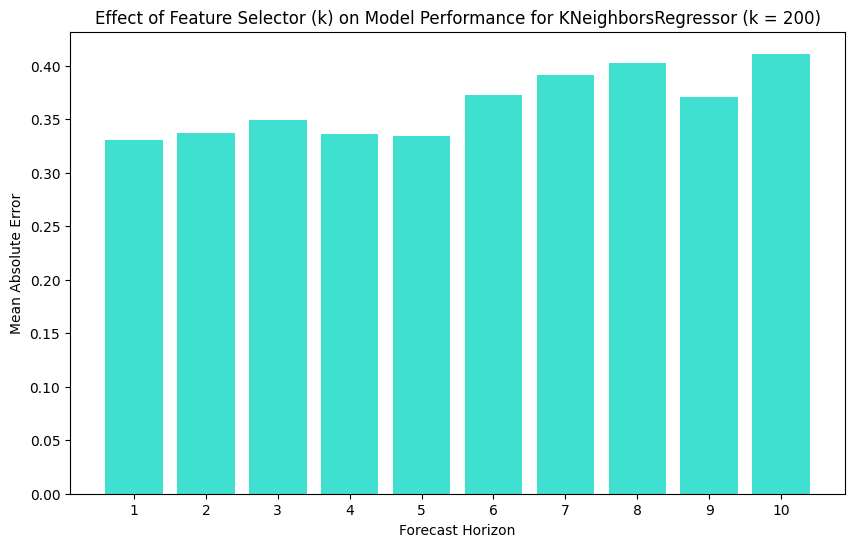

Average MAE results exported to average_mae_results.csv


In [75]:
#RUNS ABOVE CELLS
#model_mean_test_scores = {}
average_mae_results = []

for model_name, (model_constructor, hyperparameters) in regression_models.items():
    k_values = [200]
    for k in k_values:
        print('\nTraining pipeline for', model_name, 'with k =', k)
        # mean_test_scores, 
        cv_results_df, predictions, y_test = train_and_evaluate_model(model_name, model_constructor, hyperparameters, X, y, k)
        #results = regression_scores_up(y_test, predictions)
        #results_df, errors_df = regression_and_error_score(y_test, predictions, model_name, k)
        #print('\nSaved errors for', model_name, 'with k =', k)
                
        #model_mean_test_scores[model_name] = mean_test_scores
        all_predictions[model_name] = predictions

        mae = mean_absolute_error(y_test, predictions, multioutput='raw_values')
        # Store results in a dictionary
        result_entry = {
            'K-value': k,
            'Model Name': model_name,
            'Average MAE': np.mean(mae)  # Calculate average MAE
        }
        average_mae_results.append(result_entry)

average_mae_df = pd.DataFrame(average_mae_results)
average_mae_df.to_csv('Z:\Research_Projects\Lee_River\ML_discharge\output_tables_and_figs/R2_average_mae_results.csv', index=False)
print('Average MAE results exported to average_mae_results.csv')

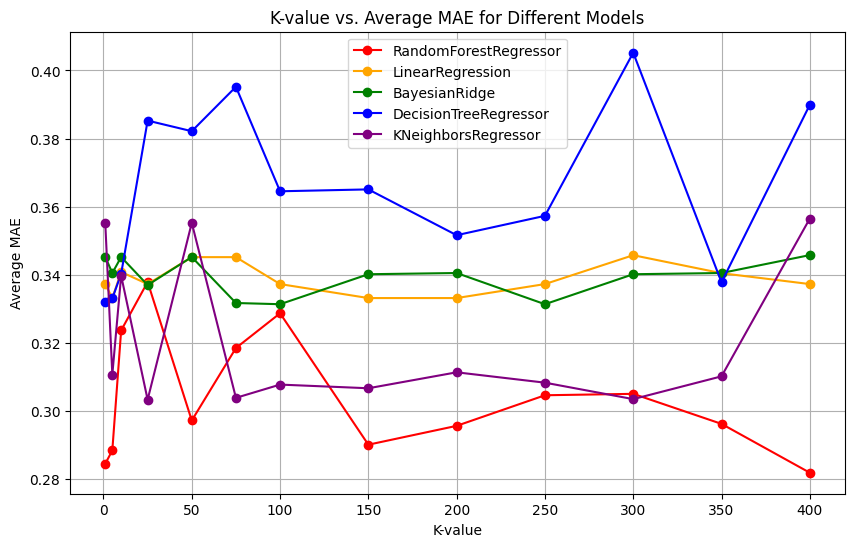

In [61]:
#lineplot for visualizing error
import matplotlib.pyplot as plt

# Assuming you already have the average_mae_df DataFrame from the previous code

# Define unique colors for each model
model_colors = {
    'RandomForestRegressor': 'red',
    'LinearRegression': 'orange',
    'BayesianRidge': 'green',
    'DecisionTreeRegressor': 'blue',
    'KNeighborsRegressor': 'purple',
}

# Plotting
plt.figure(figsize=(10, 6))

for model_name, color in model_colors.items():
    model_data = average_mae_df[average_mae_df['Model Name'] == model_name]
    plt.plot(model_data['K-value'], model_data['Average MAE'], label=model_name, color=color, marker='o')

plt.xlabel('K-value')
plt.ylabel('Average MAE')
plt.title('K-value vs. Average MAE for Different Models')
plt.legend()
plt.grid(True)
plt.show()


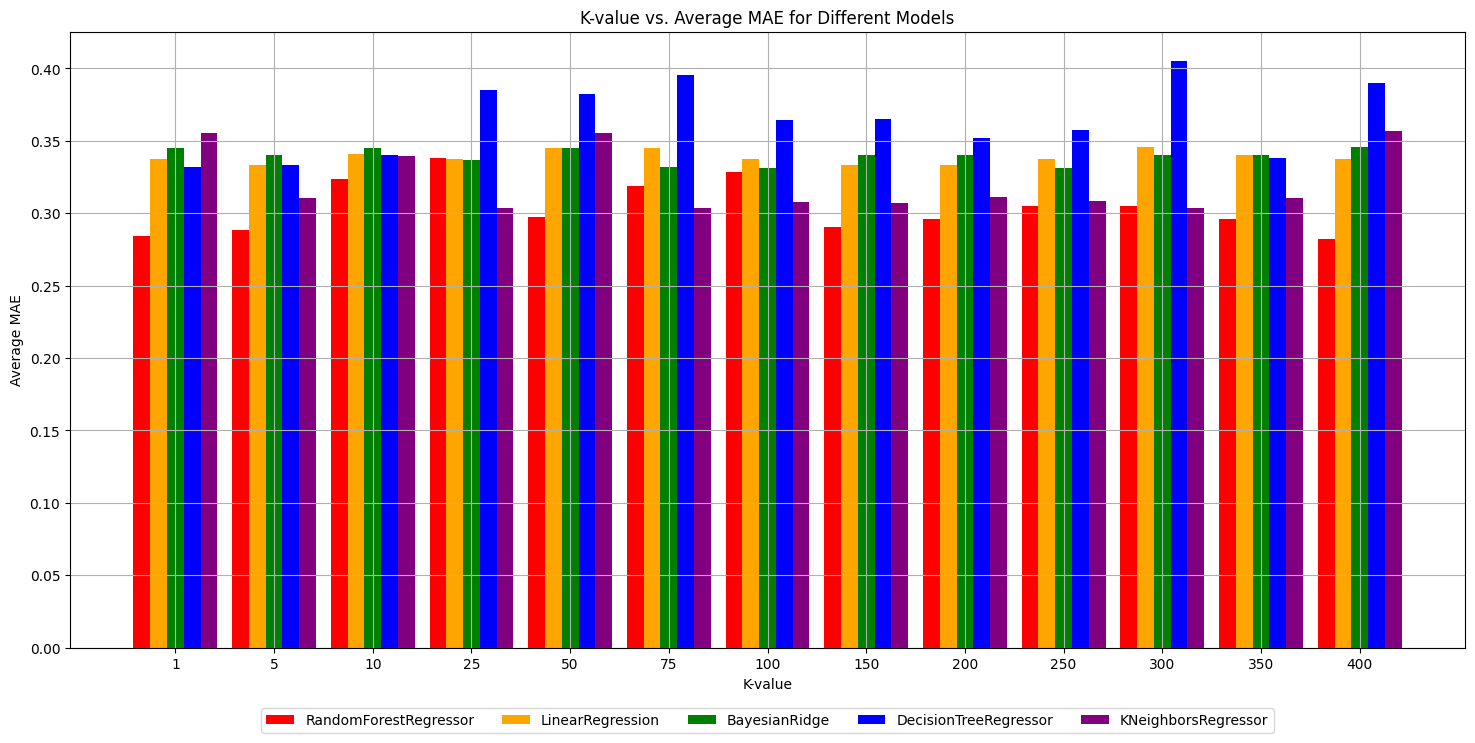

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have the average_mae_df DataFrame from the previous code

# Define unique colors for each model
model_colors = {
    'RandomForestRegressor': 'red',
    'LinearRegression': 'orange',
    'BayesianRidge': 'green',
    'DecisionTreeRegressor': 'blue',
    'KNeighborsRegressor': 'purple',
}
# Get unique k-values
k_values = average_mae_df['K-value'].unique()

# Plotting
plt.figure(figsize=(18, 8))

bar_width = 0.17  # Adjust the width of the bars as needed
index = np.arange(len(k_values))

for i, (model_name, color) in enumerate(model_colors.items()):
    model_data = average_mae_df[average_mae_df['Model Name'] == model_name]
    plt.bar(index + i * bar_width, model_data['Average MAE'], bar_width, label=model_name, color=color)

plt.xlabel('K-value')
plt.ylabel('Average MAE')
plt.title('K-value vs. Average MAE for Different Models')
plt.xticks(index + bar_width * (len(model_colors) - 1) / 2, k_values)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(model_colors))
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def calculate_mean_mae(predicted_actual_df, predicted_cols, actual_cols):
    """Calculate mean MAE for each day and add it to the DataFrame."""
    mean_mae_store = []

    for index, row in predicted_actual_df.iterrows():
        for p, a in zip(predicted_cols, actual_cols):
            mae = mean_absolute_error([row[p]], [row[a]])
            mean_mae = np.mean(mae)
            mean_mae_store.append(mean_mae)

    predicted_actual_df['MAE'] = pd.Series(mean_mae_store)
    return predicted_actual_df

def find_best_worst_average_days(predicted_actual_df):
    """Find best, worst, and average days based on MAE."""
    best_day = predicted_actual_df.loc[predicted_actual_df['MAE'].idxmin()]
    worst_day = predicted_actual_df.loc[predicted_actual_df['MAE'].idxmax()]
    average_day = predicted_actual_df.mean()

    best_day = best_day.drop('MAE')
    worst_day = worst_day.drop('MAE')
    average_day = average_day.drop('MAE')

    return best_day, worst_day, average_day

def plot_actual_vs_predicted(title, xlabel, ylabel, save_path, day, predicted_cols, actual_cols, custom_labels):
    """Plot actual vs predicted for a specific day."""
    plt.figure(figsize=(12, 6))
    plt.plot(day.index[len(predicted_cols)//2:], day.values[:len(predicted_cols)//2], label='Actual', marker='o')
    plt.plot(day.index[len(predicted_cols)//2:], day.values[len(predicted_cols)//2:], label='Predicted', marker='o')
    plt.xticks(day.index[len(predicted_cols)//2:], custom_labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(save_path)
    plt.show()

# Load the DataFrame
predicted_actual_df = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/predicted_vs_actual/Run35_RandomForestRegressor_1_predicted_vs_actual.csv')

# Define columns
predicted_cols = [f'Predicted_normalized_reservoir_height+{i}' for i in range(1, 4 + 1)]
actual_cols = [f'normalized_reservoir_height+{i}' for i in range(1, 4 + 1)]

# Calculate mean MAE for each day
predicted_actual_df = calculate_mean_mae(predicted_actual_df, predicted_cols, actual_cols)

# Find best, worst, and average days
best_day, worst_day, average_day = find_best_worst_average_days(predicted_actual_df)

# Plot the best, worst, and average days
custom_labels = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']

plot_actual_vs_predicted('Best Forecast - Actual vs Predicted (MAE=0.0016)', 'Forecast Horizon', 'Normalized Reservoir Height (m)',
                        'Z:/Research_Projects/Reservoir_Project/ML_outputs/best_forecast_rf35_csv', best_day,
                        predicted_cols, actual_cols, custom_labels)

plot_actual_vs_predicted('Worst Forecast - Actual vs Predicted (MAE=16.97)', 'Forecast Horizon', 'Normalized Reservoir Height (m)',
                        'Z:/Research_Projects/Reservoir_Project/ML_outputs/worst_forecast_rf35_csv', worst_day,
                        predicted_cols, actual_cols, custom_labels)

plot_actual_vs_predicted('Average Forecast - Actual vs Predicted (MAE=2.95)', 'Forecast Horizon', 'Normalized Reservoir Height (m)',
                        'Z:/Research_Projects/Reservoir_Project/ML_outputs/avg_forecast_rf35_csv', average_day,
                        predicted_cols, actual_cols, custom_labels)


In [ ]:
#combining error csvs into one from ML_forecasting_error_reservoir  
import os
import pandas as pd

# Directory where the CSV files are located
csv_directory = 'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH'

# List of CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.startswith('Run2F')]

# Initialize an empty DataFrame
combined_df = pd.DataFrame()

# Load and concatenate each CSV file
for csv_file in csv_files:
    file_path = os.path.join(csv_directory, csv_file)
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/combined_error_results_2F.csv', index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the combined error results CSV
error_results_df = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/combined_error_results_2F.csv')

# Get the MAE columns and unique k values
mae_columns = ["1 MAE", "2 MAE", "3 MAE", "4 MAE", "5 MAE"]
k_values = error_results_df['k'].unique()

# Calculate the width of each bar and the bar positions
bar_width = 0.08
bar_positions = np.arange(len(mae_columns))

# Define custom colors for the bars based on k values
bar_colors = plt.cm.viridis(np.linspace(0, 1, len(k_values)))

# Create a bar plot for MAE vs. forecast horizon
plt.figure(figsize=(12, 6))

for i, k in enumerate(k_values):
    # Calculate the x positions for the grouped bars
    x_positions = bar_positions + i * bar_width
    
    # Plot the bars for each k value with custom colors
    mae_values = [error_results_df[error_results_df['k'] == k][col].mean() for col in mae_columns]
    plt.bar(x_positions, mae_values, width=bar_width, label=f'K={k}', color=bar_colors[i])

# Set x-axis tick positions and labels
plt.xticks(bar_positions + (bar_width * (len(k_values) - 1)/2 ), mae_columns)


# Set plot title and labels
plt.title('MAE across different Forecast Horizons ')
plt.xlabel('Forecast Horizon')
plt.ylabel('MAE')

# Put the legend outside the plot
plt.legend(title='K Value', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.savefig('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/2F_MAE_FH_K_5_200.png')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined error results CSV
error_results_df = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/combined_error_results_2F.csv')

k_values = error_results_df['k'].unique()
mae_values = [error_results_df[error_results_df['k'] == k]['MAE'].mean() for k in k_values]

# Create a bar plot for MAE vs. k
plt.figure(figsize=(10, 6))
bars = plt.bar(k_values, mae_values, color='skyblue', width = 12)

# Set plot title and labels
plt.title('MAE vs. K Value')
plt.xlabel('K Value')
plt.ylabel('MAE')
plt.xticks(k_values)

# Show the plot
plt.savefig('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/AVG_MAE_2F.png')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/all_error_35.csv')

# Choose the error metric to plot
error_metric = 'MSE'

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot for the selected error metric
plt.bar(df['Model'], df[error_metric])

# Set plot title and labels
plt.title(f'{error_metric} Comparison for Different Regression Models')
plt.xlabel('Model Type')
plt.ylabel(f'{error_metric} Value')

# Show the plot
plt.savefig(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/35{error_metric}_comparisonmse.png')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

# Assuming all_predictions, model_name, and k_values are defined

for model_name, predictions in all_predictions.items():
    all_dataframes = []

    for k in k_values:
        results_indv = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/Run2F_'+ model_name + '_'+ str(k) +'_randomized_search_results.csv')
        results_indv['k'] = k  # Add a 'k' column to the DataFrame
        all_dataframes.append(results_indv)

    # Concatenate the dataframes along the rows
    results = pd.concat(all_dataframes, ignore_index=True)

    param_hyperparam1 = 'param_multioutput__estimator__model__max_depth'
    param_hyperparam2 = 'param_multioutput__estimator__model__n_estimators'
    param_hyperparam3 = 'param_scaler__norm'

    k_values_unique = sorted(set(k_values))
    cmap = get_cmap('gist_rainbow', len(k_values_unique))  # Use a suitable color map

    for i, k in enumerate(k_values_unique):
        # Filter the results for the current K value
        filtered_results = results[results['k'] == k]

        # Take the absolute value of mean_test_score
        filtered_results['mean_test_score'] = np.abs(filtered_results['mean_test_score'])

        # Plot the scatter plot with a unique color for each K value
        plt.scatter(filtered_results[param_hyperparam1], filtered_results['mean_test_score'], label=f'K = {k}', color=cmap(i))

    plt.xlabel('max_depth')
    plt.ylabel('MAE')
    plt.title('Randomized Search Results for ' + model_name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    #plt.savefig(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/Hyperparameters/HP_max_depth_{model_name}.png')

    for i, k in enumerate(k_values_unique):
        # Filter the results for the current K value
        filtered_results = results[results['k'] == k]

        # Take the absolute value of mean_test_score
        filtered_results['mean_test_score'] = np.abs(filtered_results['mean_test_score'])
        
        # Plot the scatter plot with a unique color for each K value
        plt.scatter(filtered_results[param_hyperparam2], filtered_results['mean_test_score'], label=f'K = {k}', color=cmap(i))

    plt.xlabel('N_estimators')
    plt.ylabel('MAE')
    plt.title('Randomized Search Results for ' + model_name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    #plt.savefig(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/Hyperparameters/HP_n_estimator_{model_name}.png')

